<a href="https://colab.research.google.com/github/bhuvnk/EVA6/blob/main/Session%205%20Coding%20Drill%20Down%20/%20Model_Training_Drill_Down_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Target

Already had a base training pipeline from previous assignment, we'll work on top of that to improve.

- Write a decent architecture to start with
- From previous assignment noticed that wide first conv-block gives good accuracy, so shall expand the first block till 32
- Mostly follow excite-squeeze methodology
- No dropout, no data augmentation
- 15 Epochs
- OneCycleLR from get go; because it works!!

### 2. Result

- Params: `10_472`
- Best Train Accuracy: `99.86%`
- Best Test Accuracy : `99.49%`

### 3. Analysis

- Model is not really overfitting, but the train-test accuracy gap can be reduced more by some dropouts
- Need to reduce the parameteres under 10000

## Model

- Convolution Block 1
    - `Conv2D:  1,  8, 3; Out: 26x26x8`
    - `Conv2D:  1, 16, 3; Out: 24x24x16`
    - `Conv2D: 16, 32, 3; Out: 22x22x32`
- Transition Block
    - `Conv2D: 32, 08, 1; Out: 22x22x8`
    - `MaxPool2D: 2x2;    Out: 11x11x8`
- Convolution Block 2
    - `Conv2D:  8,  8, 3; Out: 9x9x8`
    - `Conv2D:  8, 16, 3; Out: 7x7x16`
    - `Conv2D: 16, 16, 3; Out: 5x5x16`
- GAP
    - `AdaptiveAvgPool2d: -;    Out: 1x1x16`
    - `Conv2D:  -, 10, 1; Out: 1x1x10`

In [ ]:
!nvidia-smi

Fri Jun  4 17:18:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
drop_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # dims : [28,28,1];
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, bias=False), # 26
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout2d(drop_value),
            # RF - 3x3

            nn.Conv2d(8, 16, 3, bias=False), # 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(drop_value),
            # RF - 5x5

            nn.Conv2d(16, 32, 3, bias=False), # 22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout2d(drop_value),
            # RF - 7x7
        )

        # dims : [22x22x32]
        # Bottle neck - Transition layer

        self.trans1 = nn.Sequential(
            nn.Conv2d(32, 8, 1, bias=False), # 22
            nn.ReLU(),
            # RF - 7x7

            nn.MaxPool2d(2, 2), # 11
            # RF - 14x14
        )

        # dims : [11x11x8]
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, bias=False), # 9
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout2d(drop_value),
            # RF - 16x16

            nn.Conv2d(8, 16, 3, bias=False), # 7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(drop_value),
            # RF - 18x18

            nn.Conv2d(16, 16, 3, bias=False), # 5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(drop_value),
            # RF - 20x20
        )

        # dims : 5x5x32

        # GAP Layer
        self.out = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),       # 
            nn.Conv2d(16, 10, 1, bias=False), # 5
            # RF - 22x22
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.out(x)

        x = x.view(-1, 10)
        return F.log_softmax(x)

## parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 32, 22, 22]           4,608
              ReLU-8           [-1, 32, 22, 22]               0
       BatchNorm2d-9           [-1, 32, 22, 22]              64
           Conv2d-10            [-1, 8, 22, 22]             256
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Conv2d-13              [-1, 8, 9, 9]             576
             ReLU-14              [-1, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # Added asjed
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # init by setting the gradients to zero
        optimizer.zero_grad()

        #Predict
        output = model(data)

        #Loss Calculation
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        
        # BackProp
        loss.backward()
        optimizer.step()

        # lr changes
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training

In [ ]:
N_EPOCH = 15
BASE_LR = 0.001
MAX_LR = 0.15
STEP_UP = int(N_EPOCH/5)

from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR,
                                                steps_per_epoch=len(train_loader),
                                                epochs=N_EPOCH)



for epoch in range(1, N_EPOCH+1):
    print('\nEpoch {} and Learning Rate {}: '.format(epoch, scheduler.get_last_lr()))
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1 and Learning Rate [0.006000000000000005]: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.036800216883420944 batch_id=468 Accuracy=90.90: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1272, Accuracy: 9612/10000 (96.12%)


Epoch 2 and Learning Rate [0.0228601195551989]: 


loss=0.03907253220677376 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9808/10000 (98.08%)


Epoch 3 and Learning Rate [0.06554426623702893]: 


loss=0.017530130222439766 batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9892/10000 (98.92%)


Epoch 4 and Learning Rate [0.11406188959639837]: 


loss=0.04129451885819435 batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9881/10000 (98.81%)


Epoch 5 and Learning Rate [0.14569040823405507]: 


loss=0.003119424916803837 batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)


Epoch 6 and Learning Rate [0.1491551691239221]: 


loss=0.03509989008307457 batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)


Epoch 7 and Learning Rate [0.14255192137417153]: 


loss=0.029933614656329155 batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9917/10000 (99.17%)


Epoch 8 and Learning Rate [0.12994641561991813]: 


loss=0.008031661622226238 batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)


Epoch 9 and Learning Rate [0.1124587063657782]: 


loss=0.008840284310281277 batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)


Epoch 10 and Learning Rate [0.09164265332253009]: 


loss=0.05460173264145851 batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)


Epoch 11 and Learning Rate [0.06934785415281057]: 


loss=0.0041853501461446285 batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9929/10000 (99.29%)


Epoch 12 and Learning Rate [0.04755529960196385]: 


loss=0.004390938673168421 batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)


Epoch 13 and Learning Rate [0.028201353776883133]: 


loss=0.0027310934383422136 batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9946/10000 (99.46%)


Epoch 14 and Learning Rate [0.013005699697519156]: 


loss=0.0017765542725101113 batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)


Epoch 15 and Learning Rate [0.0033185379138529515]: 


loss=0.002154627116397023 batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)



## Logs

Text(0.5, 1.0, 'Test Accuracy')

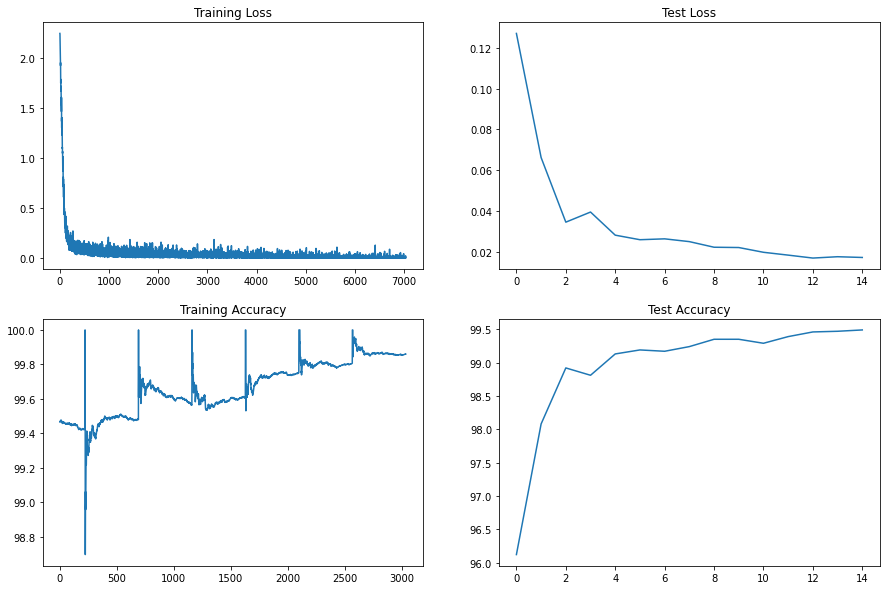

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")